First 2 cells are just mounting to the google drive and moving files & annotations to train,valid,test,folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pathlib import Path
import shutil
from tqdm import tqdm
import os

image_dir = "/content/drive/My Drive/helmet-dataset/images"
anno_dir = "/content/drive/My Drive/helmet-dataset/annotations"

path_annotations = []
for i in Path(anno_dir).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations) #contains path to 5000 annots

path_images = []
for i in Path(image_dir).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images) #contains path to 5000 images


# Split data : 90% Train, 10% Val
path_train_annot = path_annotations[:4000]
path_train_images = path_images[:4000]

path_val_annot = path_annotations[4000:4500]
path_val_images = path_images[4000:4500]

path_test_annot = path_annotations[4500:5000]
path_test_images = path_images[4500:5000]


# Creating directories to put train & val data
os.makedirs('/content/drive/My Drive/helmet_dataset/train/annotations',exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/train/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/val/annotations', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/val/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/test/annotations', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/test/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/savedmodel', exist_ok = True)


#Copy data into train and val folders
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/train/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/train/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/val/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_test_annot, path_test_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/test/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/test/annotations/' + path_annot.parts[-1])

#djusting the data file structure - comment it out once it is done, only to be run once.
#The above code needs to be run only once - and we can use CPU for all these operations.

import torch
from pathlib import Path
import shutil
from tqdm import tqdm
import os

BATCH_SIZE = 8 #increase / decrease according to memory
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '/content/drive/My Drive/helmet_dataset/train'
# validation images and XML files directory
VALID_DIR = '/content/drive/My Drive/helmet_dataset/val'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)


4000it [23:28,  2.84it/s]
500it [02:20,  3.55it/s]
500it [02:13,  3.75it/s]


Below is the code for albumentations(Data augmentation & resizing the image for the pipeline)

In [ ]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Resize(415,415),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        A.Resize(415,415),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [ ]:
# Prepare the pytorch dataset
from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET
from pathlib import Path

# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)
class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)


    def __getitem__(self, idx: int):
        image_name = self.all_images[idx] #reading image one by one

        image = plt.imread(image_name) #read the image
        image /= 255.0 #normalize pixels b/w 0 & 1

        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')

        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot() #reading xml file

        # extracting box coordinates from xml annotations
        for member in root.findall('object'):
            # map the current object name to classes to get the label index
            labels.append(self.class_name.index(member.find('name').text))

            # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target #these are the o/p of this class


    def __len__(self):
        return len(self.all_images)

In [ ]:
import torch
from pathlib import Path
import shutil
from tqdm import tqdm
import os

BATCH_SIZE = 8 #increase / decrease according to memory
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '/content/drive/My Drive/helmet_dataset/train'
# validation images and XML files directory
VALID_DIR = '/content/drive/My Drive/helmet_dataset/val'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)
train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())

In [ ]:
train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)
optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0005)

In [ ]:
from tqdm import tqdm


def train(train_data_loader, model):
    print('Training...')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    # criterion = torch.nn.BCELoss(size_average=True)

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad() #####
        images, targets = data #####

        images = list(image.to(DEVICE) for image in images) #####
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets] #####

        loss_dict = model(images, targets) #####
        losses = sum(loss for loss in loss_dict.values()) #####
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward() #####
        optimizer.step() #####
        train_itr += 1 #####

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    print(losses)

    return train_loss_list

In [ ]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/best_model.pth')


# function to save the model after each epoch and after training ends
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/last_model.pth')

In [ ]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all
# iterations till end and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()
BATCH_SIZE = 12 #increase / decrease according to memory
NUM_EPOCHS = 3 # number of epochs to train for
NUM_WORKERS = 2

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    # save the current epoch model
    save_model(epoch, model, optimizer)


EPOCH 1 of 3
Training...


Loss: 0.6321: 100%|██████████| 500/500 [13:17<00:00,  1.59s/it]


tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)
Validating...


Loss: 0.4686: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


Epoch #1 train loss: 0.630
Epoch #1 validation loss: 0.576

Best validation loss: 0.576

Saving best model for epoch: 1


EPOCH 2 of 3
Training...


Loss: 0.7513: 100%|██████████| 500/500 [12:42<00:00,  1.53s/it]


tensor(0.7513, device='cuda:0', grad_fn=<AddBackward0>)
Validating...


Loss: 0.3915: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


Epoch #2 train loss: 0.518
Epoch #2 validation loss: 0.482

Best validation loss: 0.482

Saving best model for epoch: 2


EPOCH 3 of 3
Training...


Loss: 0.4436: 100%|██████████| 500/500 [12:43<00:00,  1.53s/it]


tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)
Validating...


Loss: 0.3262: 100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


Epoch #3 train loss: 0.457
Epoch #3 validation loss: 0.459

Best validation loss: 0.459

Saving best model for epoch: 3



In [ ]:
# load the best model and trained weights
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/content/drive/My Drive/helmet_dataset/savedmodel/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# any detection having score below this will be discarded, i.e bbox with scores more than 0.8
# will be shown, less than the threshold will not be shown
detection_threshold = 0.85

In [ ]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join('/content/drive/My Drive/helmet_dataset/val/annotations/', Path(img_path).parts[-1][:-4] + '.xml')
    print(annot_filepath)
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])

    return boxes, labels

In [ ]:
# foll are various func to draw predicted bounding boxes & labels
import matplotlib.patches as patches, numpy as np

def img_show(img, ax = None, figsize=(16,8)):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

def draw_box(ax, bb, lbl):
    if lbl=='helmet': # 1=helmet
        color_lbl='yellow'
    elif lbl=='head': # 2=head
        color_lbl='red'
    else:
        color_lbl='blue'

    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)


def plot_pred(ax, tboxes, tlbls):
    for i in range(len(tboxes)):
        draw_box(ax, tboxes[i], tlbls[i])

def plot_act(img, boxes, ax=None, figsize=(16,8)):
    ax = img_show(img, ax=ax)
    for i in range(len(boxes)):
        rect = patches.Rectangle(
            (int(boxes[i][0]),int(boxes[i][1])), int(boxes[i][2])-int(boxes[i][0]), int(boxes[i][3])-int(boxes[i][1]),
            fill=False, edgecolor='green', lw=2
            )
        ax.add_patch(rect)
    return ax

In [ ]:
def compare_prediction_with_actual(image_path, image_name):
    image = plt.imread(image_path+"/"+image_name)
    img = image.copy()
    input_image=(image_path+"/"+image_name)
    # bring color channels to front
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)

    # convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
    img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled

    # add batch dimension
    img = torch.unsqueeze(img, 0)
    with torch.no_grad(): #forward pass
        outputs = model(img.to(DEVICE))
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    # draw actual bounding boxes (to compare with predicted boxes)
    act_box, act_lbl = get_box_lbl(input_image) #get actual boxes & labels
    ax = plot_act(image, act_box)

    p_voc_format_act_box = {}
    p_voc_format_act_box[image_name] = act_box

    p_voc_format_pred_box = {}
    print(f"Actual number of Boxes: {len(act_box)}")
    print(f"Actual boxes: {act_box}")

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) > 0:
        boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
        scores = outputs[0]['scores'].data.numpy()
        lbls = outputs[0]['labels'].data.numpy()

        print(f"Detection Threshold: {detection_threshold}")
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores > detection_threshold].astype(np.int32)

        lbls = lbls[scores > detection_threshold].astype(np.int32)
        pred_boxes = boxes.copy()

        scores = scores[scores > detection_threshold].astype(np.float32)
        # Returning only the boxes and scores which are above the detection_threshold
        p_voc_format_pred_box[image_name] = {'boxes':boxes,'scores':scores}

        print(f"Predicted number of Boxes: {len(pred_boxes)}")
        print(f"Predicted boxes: {pred_boxes}")
        # get all the predicited class names
        pred_class = [CLASS_NAME[i] for i in lbls]

        # draw predicted boxes (to compare with actuals)
        plot_pred(ax, pred_boxes, pred_class)
    print("ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE")
    return p_voc_format_act_box, p_voc_format_pred_box

/content/drive/My Drive/helmet_dataset/val/annotations/hard_hat_workers4918.xml
Actual number of Boxes: 7
Actual boxes: [[332, 130, 367, 168], [59, 141, 95, 185], [168, 146, 201, 184], [280, 153, 308, 186], [93, 146, 116, 180], [229, 143, 258, 177], [12, 161, 45, 188]]
Detection Threshold: 0.85
Predicted number of Boxes: 11
Predicted boxes: [[280 152 307 179]
 [230 143 256 176]
 [ 59 140  96 188]
 [ 14 159  42 190]
 [170 150 198 184]
 [332 129 364 174]
 [ 91 148 116 180]
 [254 393 281 416]
 [339 398 354 416]
 [124 401 166 416]
 [ 51 400  65 416]]
ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE


({'hard_hat_workers4918.png': [[332, 130, 367, 168],
   [59, 141, 95, 185],
   [168, 146, 201, 184],
   [280, 153, 308, 186],
   [93, 146, 116, 180],
   [229, 143, 258, 177],
   [12, 161, 45, 188]]},
 {'hard_hat_workers4918.png': {'boxes': array([[280, 152, 307, 179],
          [230, 143, 256, 176],
          [ 59, 140,  96, 188],
          [ 14, 159,  42, 190],
          [170, 150, 198, 184],
          [332, 129, 364, 174],
          [ 91, 148, 116, 180],
          [254, 393, 281, 416],
          [339, 398, 354, 416],
          [124, 401, 166, 416],
          [ 51, 400,  65, 416]], dtype=int32),
   'scores': array([0.9963652 , 0.99471056, 0.99424416, 0.9913292 , 0.9852887 ,
          0.98364544, 0.979784  , 0.9194467 , 0.8940397 , 0.8576183 ,
          0.85157734], dtype=float32)}})

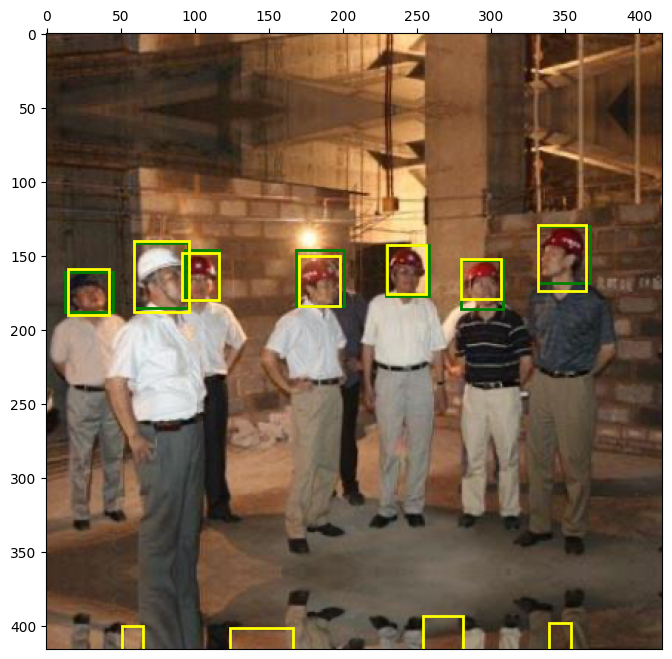

In [ ]:
#validation of the bounding box
import random
input_image = ("/content/drive/My Drive/helmet_dataset/val/images/hard_hat_workers998.png")
image_path = "/content/drive/My Drive/helmet_dataset/val/images"

file_names = os.listdir(image_path)
image_name = random.choice(file_names)

compare_prediction_with_actual(image_path, image_name)